In [1]:
# Reload the notebook if an external file is updated
%load_ext autoreload
%autoreload 2

import sys
import warnings

from pathlib import Path
from tqdm import TqdmExperimentalWarning

path = str(Path.cwd().parent)
sys.path.append(path)

warnings.simplefilter(
    'ignore', 
    TqdmExperimentalWarning
)

In [16]:
import matplotlib.pyplot as plt
import numpy as np

from avgn.signalprocessing.create_spectrogram_dataset import (
    flatten_spectrograms,
    make_spec,
    log_resize_spec,
    pad_spectrogram,
)
from avgn.signalprocessing.filtering import prepare_mel_matrix
from avgn.visualization.projections import (
    scatter_projections,
    scatter_spec,
    draw_projection_transitions,
)
from avgn.visualization.quickplots import draw_projection_plots
from avgn.visualization.spectrogram import draw_spec_set
from constant import DATASET, SETTINGS
from datatype.dataset import Dataset
from datatype.settings import Settings
from joblib import Parallel, delayed
from pathlib import Path
from tqdm.autonotebook import tqdm
from umap import UMAP

In [3]:
import logging
import numpy as np
import swifter

from bootstrap import bootstrap
from constant import SETTINGS
from datatype.dataset import Dataset
from datatype.imaging import (
    create_image,
    filter_image,
    to_bytes,
    to_numpy
)
from datatype.settings import Settings
from datatype.spectrogram import (
    create_spectrogram,
    mel_matrix,
    pad,
    resize
)
from logger import logger

In [4]:
swifter.set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler='processes',
    progress_bar=False,
    progress_bar_desc=False,
    allow_dask_on_strings=True,
    force_parallel=True,
)

In [5]:
dataset = Dataset('avgn')
dataframe = dataset.load()

In [7]:
dataframe.reset_index(drop=True, inplace=True)
dataframe = dataframe.copy()

dataframe['original'] = (
    dataframe['spectrogram']
    .apply(
        lambda x: create_image(x)
    )
)

dataframe['original_array'] = (
    dataframe['original']
    .swifter
    .apply(
        lambda x: to_numpy(x)
    )
)

dataframe['original_bytes'] = (
    dataframe['original']
    .swifter
    .apply(
        lambda x: to_bytes(x)
    )
)

dataframe['filter_array'] = (
    dataframe['original']
    .swifter
    .apply(
        lambda x: filter_image(x)
    )
)

dataframe['filter_bytes'] = (
    dataframe['filter_array']
    .swifter
    .apply(
        lambda x: to_bytes(x)
    )
)

Text(0.5, 1.0, "Adelaide's warbler")

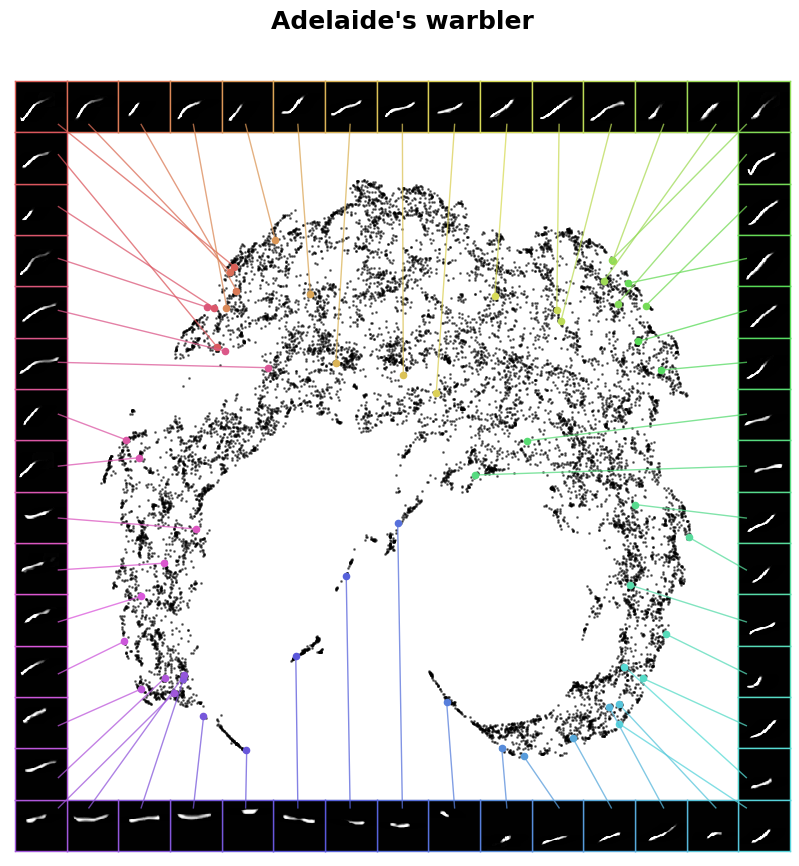

In [17]:
by = ['start_time']
ascending = [True]

dataframe = dataframe.sort_values(ascending=ascending, by=by)

spectrogram = dataframe.filter_array.tolist()

flattened = flatten_spectrograms(spectrogram)

fit = UMAP(
    low_memory=True,
    metric='euclidean',
    min_dist=0.0,
    n_neighbors=10,
    n_components=2,
    n_jobs=-1
)

projection = fit.fit_transform(flattened)
projection = list(projection)

dataframe['umap'] = projection

_, _, ax, _ = scatter_spec(
    projection,
    spectrogram,
    column_size=15,
    pal_color='hls',
    color_points=True,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs={
        'alpha': 0.50,
        's': 1,
        'show_legend': False
    },
    matshow_kwargs={
        'cmap': plt.cm.Greys
    },
    line_kwargs={
        'alpha': 0.75,
        'lw': 1,
        'ls': 'solid'
    },
    draw_lines=True
)

ax.set_title(
    'Adelaide\'s warbler',
    fontsize=18,
    fontweight=700,
    pad=75
)